# Customer Segmentation

## Package imports

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

### Data set import
The data set has already been cleaned using the Python script `clean.py`

In [50]:
data = pd.read_csv("./data/clean_df_1.csv")

## Feature Engineering

In [51]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for value in data["Dt_Customer"]:
    value = value.date()
    dates.append(value)

print("Oldest customer join date: ", min(dates))
print("Newest customer join date:", max(dates))

# Get newest customer date
number_of_days = []
ref_date = max(dates)
for d in dates:
    delta = ref_date - d
    number_of_days.append(delta)

# Create 'Customer_For' feature
data["Customer_For"] = number_of_days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="raise")



Oldest customer join date:  2012-01-08
Newest customer join date: 2014-12-06


Explore unique values in categorical features to get a clearer picture of data

In [52]:
print("Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Education:\n", data["Education"].value_counts(), "\n")

Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64 



### Further feature engineering

In [53]:
# Age of customers as of 01/11/2021
data["Age"] = 2021 - data["Year_Birth"]

# Total amount spend
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + \
    data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

# Derive household living situation by marital status
data["Living_With"] = data["Marital_Status"].replace(
    {"Married": "Partner",
     "Together": "Partner",
     "Absurd": "Alone",
     "Widow": "Alone",
     "YOLO:": "Alone",
     "Divorced": "Alone",
     "Single": "Alone",
     })

# Total children living at home
data["Children"] = data["Kidhome"] + data["Teenhome"]

# Total household members
data["Family_Size"] = data["Living_With"].map(
    {"Alone":1,
     "Partner":2}
) + data["Children"]

# Drop NAs acquired due to failed parsings
data["Family_Size"].dropna().astype(int)

# Parenthood feature
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

# Divide education levels in three categories
data["Education"] = data["Education"].replace(
    {"Basic": "Undergraduate",
     "2n Cycle": "Undergraduate",
     "Graduation": "Graduate",
     "Master": "Postgraduate",
     "PhD": "Postgraduate"}
)

# Improve clarity
data = data.rename(columns={"MntWines": "Wines",
                            "MntFruits": "Fruits",
                            "MntFishProducts": "Fish",
                            "MntSweetProducts": "Sweets",
                            "MntGoldProducts": "Gold"}
                   )

# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue",
           "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [54]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,MntMeatProducts,Fish,Sweets,MntGoldProds,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2214.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.593044,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905956,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Some discrepancies are observed in the mean Income and Age features, as well as the max Income and Age.

Note: Max age is 128 years as it is caclculated as of today 01/11/2021 and the data has not been collected very recently.

<Figure size 576x396 with 0 Axes>

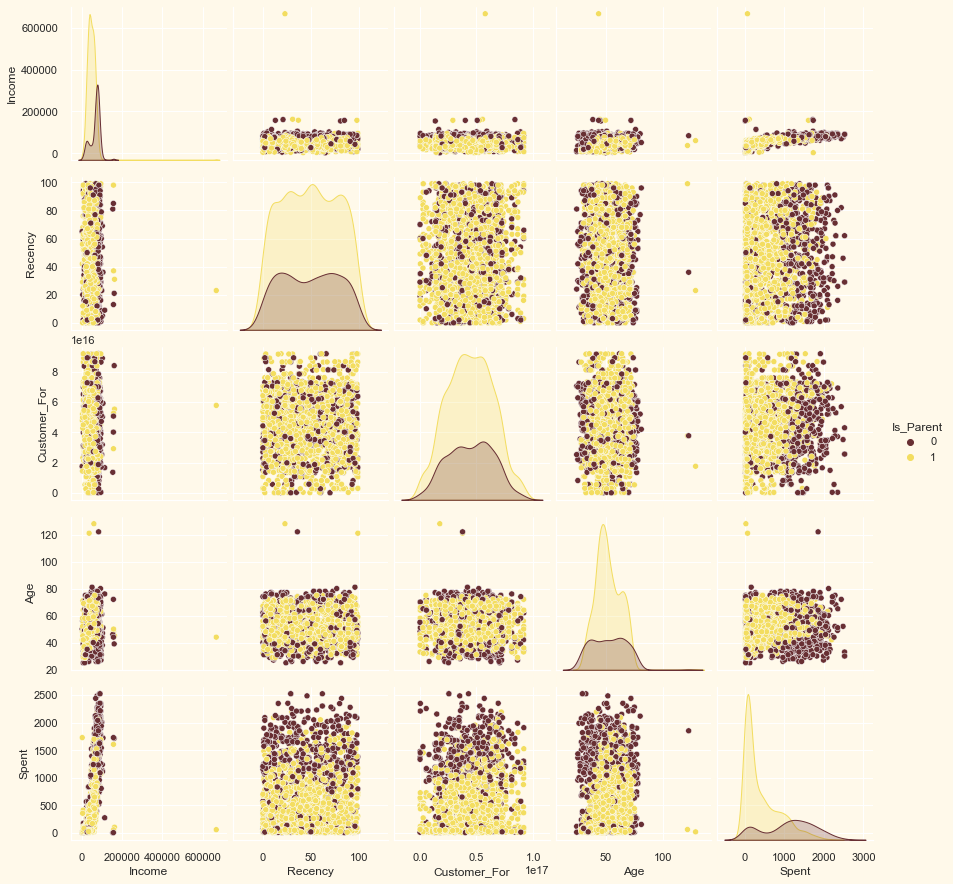

In [55]:
# Plot select features for visual analysis

# Set up colours
sns.set(rc={
    "axes.facecolor":"#FFF9EA",
    "figure.facecolor":"#FFF9EA"
})
pallet = ["#682F33", "#9E713A", "#D3B3B1", "#B9C0C9", "#9F8A78", "#F3DD60"]
cmap = colors.ListedColormap(pallet)

# Plot features
feats = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

plt.figure()
sns.pairplot(data[feats], hue = "Is_Parent", palette = (["#682F33", "#F3DD60"]))
plt.show()

There are some outliers in the Age and Income features.

In [56]:
# Drop outliers by setting limits on Income and Age
data = data[(data["Age"] < 90)]
data = data[(data["Income"] < 600000)]

Analysis of correlation amongst features (quantitative attributes only)

<AxesSubplot:>

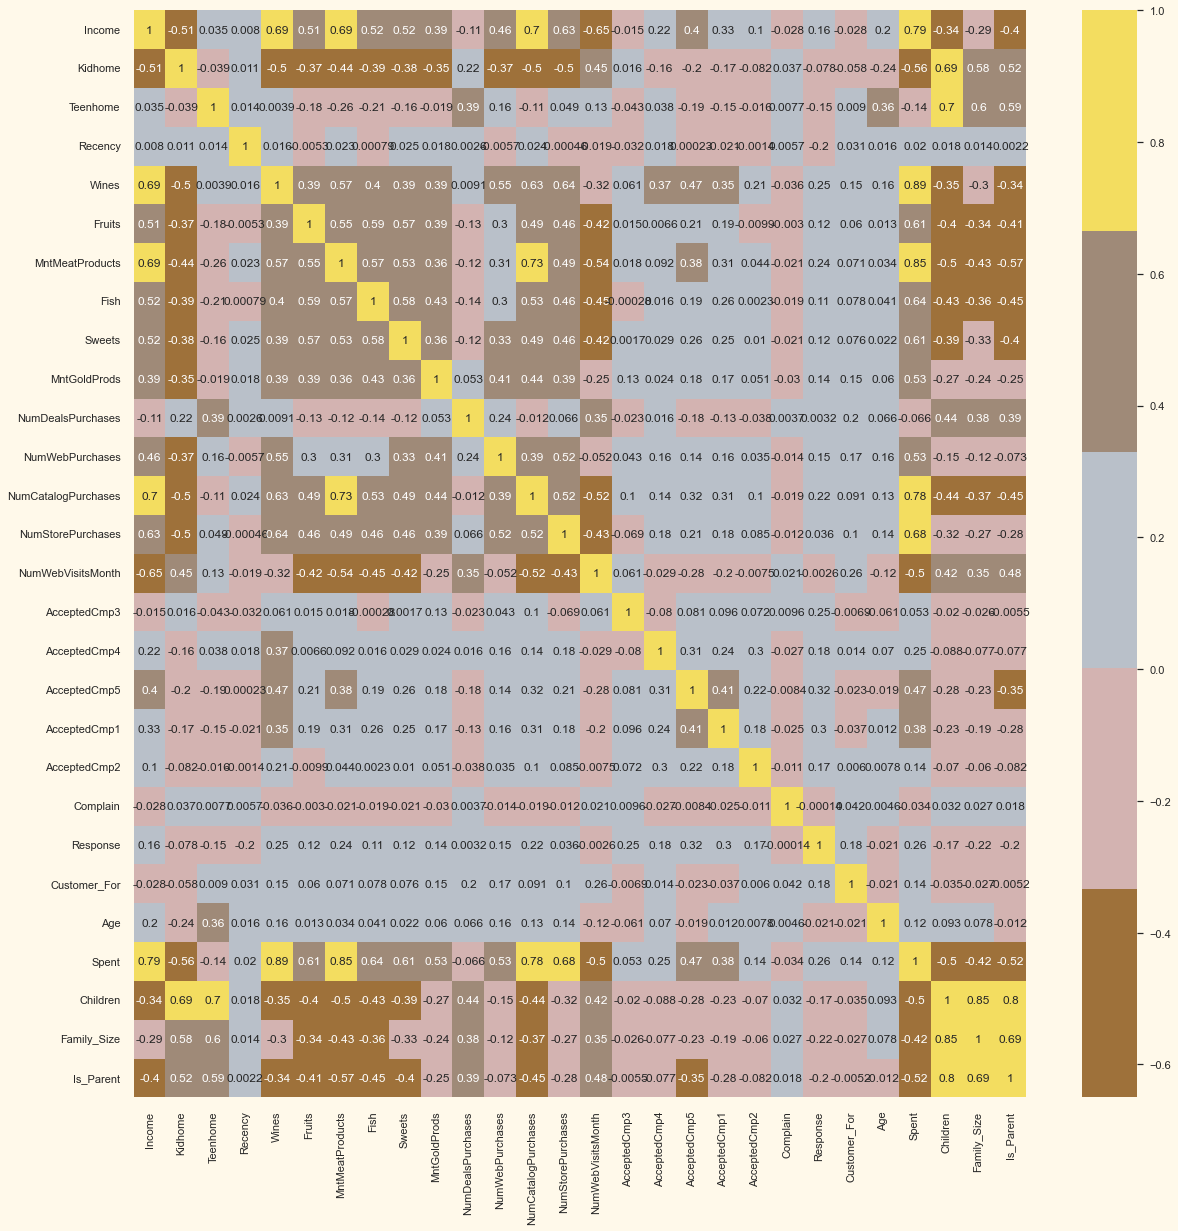

In [57]:
cm_plot = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cm_plot, annot=True, cmap=cmap, center=0)

New features have been included and the data has been cleaned.

## Data Preprocessing

In [58]:
# Build a list of categorical variables
objs = (data.dtypes == 'object')
object_cols = list(objs[objs].index)

print("Categorical variables: ", object_cols)

# Label encode object dtypes
LabEnc = LabelEncoder()
for obj in object_cols:
    data[obj] = data[[obj]].apply(LabEnc.fit_transform)

Categorical variables:  ['Education', 'Living_With']


All features have been encoded to numerical values.

In [59]:
# Subset dataframe
df_subset = data.copy()

cols_delete = ["AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1",
                "AcceptedCmp2", "Complain", "Response"]

df_subset = df_subset.drop(cols_delete, axis=1)

# Scale data
scaler = StandardScaler()
scaler.fit(df_subset)
scaled_df = pd.DataFrame(scaler.transform(df_subset), columns=df_subset.columns)

All features have now been scaled.

## Dimensionality Reduction

The final classification to be applied is based on several factors - basically, features. A higher number of features increases the difficulty of implementation. Since many such features are related, many of them are therefore redundant. Therefore, a suitable solution to this is dimensionality reudction on selected features before classification.

*Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.*

A common technique for reducing dimensionality of data sets is **Principal Component Analysis (PCA)**. This technique improves readability with minimal loss of data.

For this data set, the dimensionality will be reduced to 3.

In [60]:
pca = PCA(n_components=3)
scaled_df.dropna(inplace=True)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1", "col2", "col3"]))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2210.0,4.501176e-17,2.879505,-5.968787,-2.539825,-0.776770,2.393180,7.443331
col2,2210.0,-3.215126e-17,1.707236,-4.312268,-1.327392,-0.160162,1.244424,6.144022
col3,2210.0,5.063823e-17,1.220315,-3.474914,-0.820667,-0.015635,0.799689,6.614317


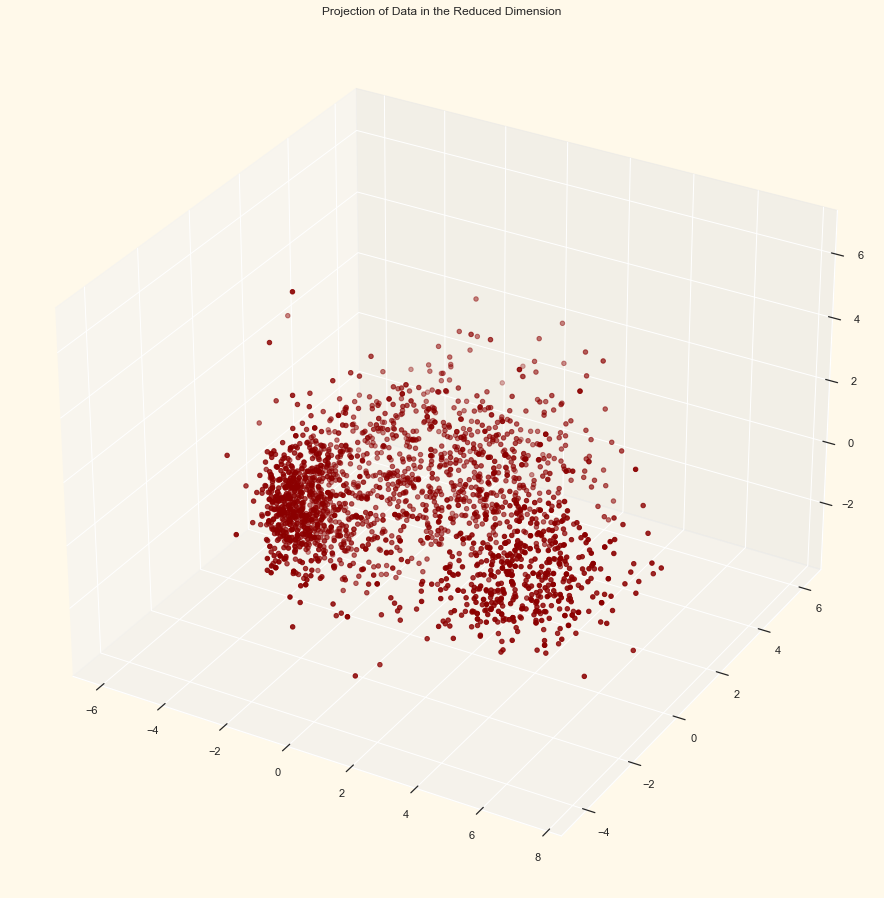

In [61]:
# 3D data visualisation in reduced dimension
x = PCA_df["col1"]
y = PCA_df["col2"]
z = PCA_df["col3"]

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x, y, z, c = "darkred", marker = "o")
ax.set_title("Projection of Data in the Reduced Dimension")
plt.show()

## Clustering

Agglomerative clustering will be performed. This is a hierarchical clustering method and it involves using examples until the desired number of clusters is achieved.

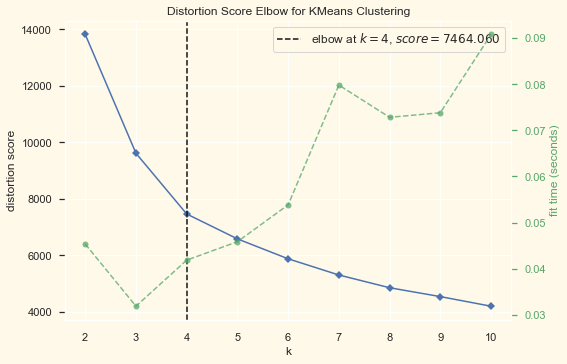

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
# Elbow method to find number of clusters to generate
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(PCA_df)
elbow.show()

The Elbow Method plot above indicates that the optimal number of clusters for this data set is 4.
The next step is to fit the Agglomerative Clustering Model to produce the final clusters.

In [63]:
# Initialise model
AC = AgglomerativeClustering(n_clusters=4)

# Fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = yhat_AC

# Add Clusters feature to original dataframe
data.dropna(inplace=True)
data["Clusters"] = yhat_AC

Visualise 3D distribution of formed clusters

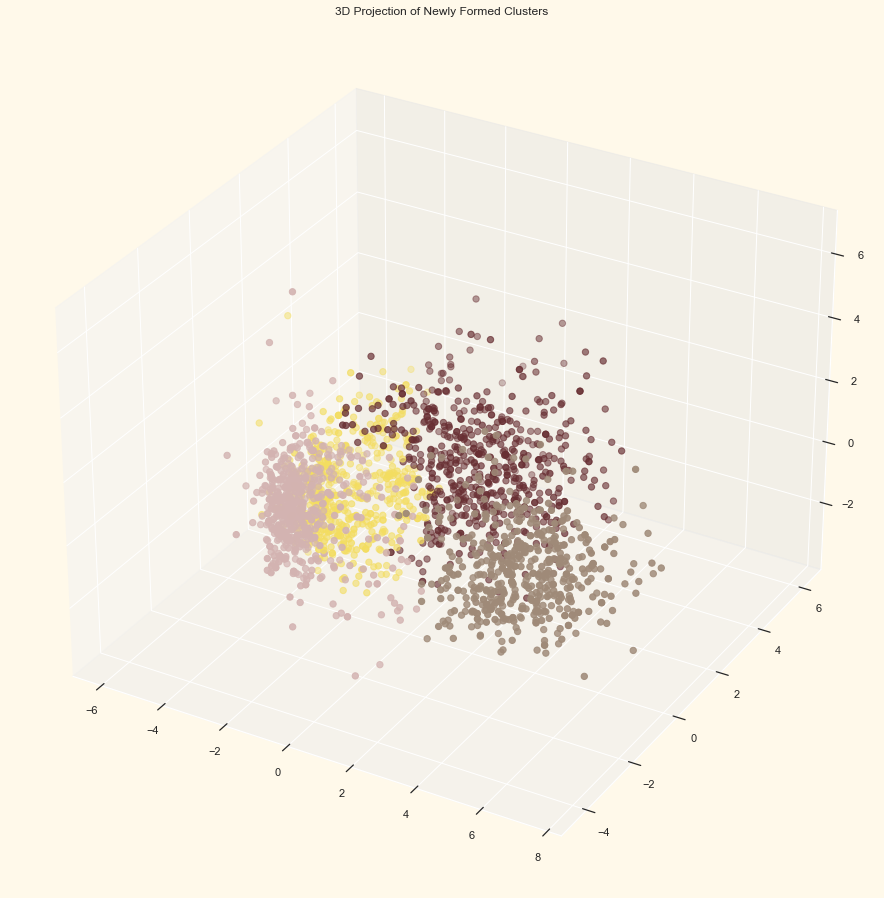

In [64]:
# Plot clusters
fig_3d = plt.figure(figsize=(18,16))
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker="o", cmap=cmap)
ax.set_title("3D Projection of Newly Formed Clusters")
plt.show()

## Model Evaluation

As this type of clusterin is unsupervised, there is no tagged feature to evaluare or score our model. Therefore, this section will study the patterns in the clusters formed and detemine the nature of these patterns.

For this, exploratory data analysis (EDA) will be conducted and conclusions will therefore be drawn.

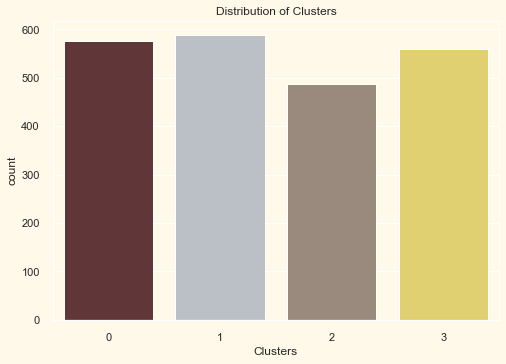

In [65]:
# Plot bar chart of cluster sizes
bar_pallet = ["#682F33", "#B9C0C9", "#9F8A78", "#F3DD60"]
bar_plot = sns.countplot(x=data["Clusters"], palette=bar_pallet)
bar_plot.set_title("Distribution of Clusters")
plt.show()

As observed in the bar plot, the clusters seem to be distributed somewhat evenly.

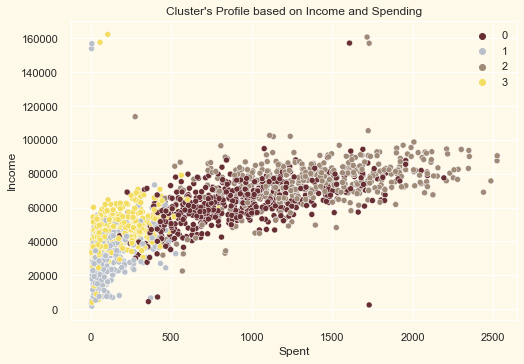

In [66]:
# Plot scatterplot
sct_plot = sns.scatterplot(data=data, x=data["Spent"], y=data["Income"],
                           hue=data["Clusters"], palette=bar_pallet)
sct_plot.set_title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

The following patterns are identified:
- Group 0: average spending & average income
- Group 1: low spending & low income
- Group 2: high spending & high income
- Group 3: low spending & high income

Namely, the detailed distribution of clusters according to various products will be examined. These products include: Wines, Fruits, Meat, Fish, Sweets and Gold.

C:\Users\julian.gherghel\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\julian.gherghel\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 74.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\julian.gherghel\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\julian.gherghel\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 64.8% of the points cannot be placed; you may want to decrease the size of the markers o

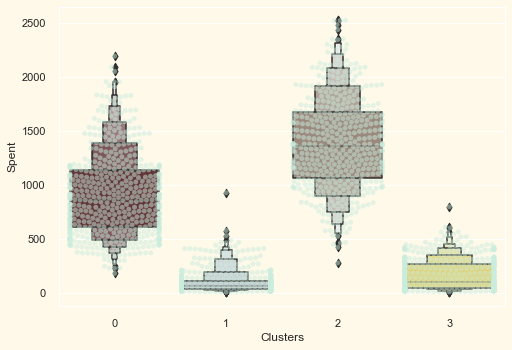

In [67]:
plt.figure()
det_dis = sns.swarmplot(x=data["Clusters"], y=data["Spent"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=bar_pallet)
plt.show()

It can be observed that Cluster 2 is the largest set of customers, very closely followed by Cluster 0. Further marketing value can be extracted from exploration of each cluster's spending habits for targeted marketing strategies.

Next, the previous campaigns' performance will be assessed

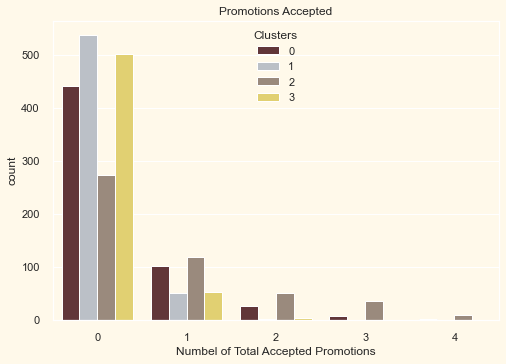

In [68]:
# Feature of summed accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

# Plot count of total campaign promotions accepted
plt.figure()
cpl = sns.countplot(x=data["Total_Promos"], hue=data["Clusters"], palette=bar_pallet)
cpl.set_title("Promotions Accepted")
cpl.set_xlabel("Numbel of Total Accepted Promotions")
plt.show()

Overall, there have been very few participants in the campaign. Additionally, no customers took part in all 5 campaigns.
Perhaps better-targeted and better-planned campaigns are required in order to boost sales.

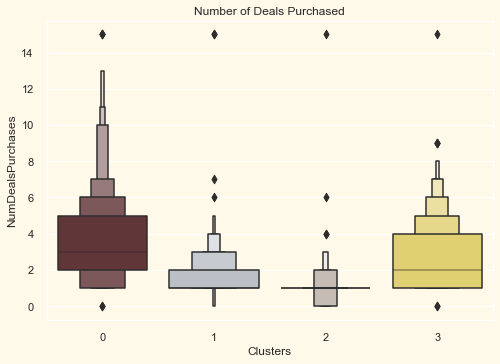

In [69]:
# Plot number of deals purchased
plt.figure()
bpl = sns.boxenplot(y=data["NumDealsPurchases"], x=data["Clusters"], palette=bar_pallet)
bpl.set_title("Number of Deals Purchased")
plt.show()

Unlike the promotional campaigns, the promotional deals performed well. The best outcomes are highlighted with Clusters 0 and 3. However, the premium customers from Cluster 2 do not appear to be affected by promotional deals. Additionally, Cluster 2 customers do not appear to be overwhelmingly attracted.

## Profiling

Clusters will now be profiled to establish the customers' characteristics for each customer group and conclude on who the star customers are and who requires a higher degree of attention from the marketing team.
In order to establish this, features representing personal traits will be plotted by cluster.

<Figure size 576x396 with 0 Axes>

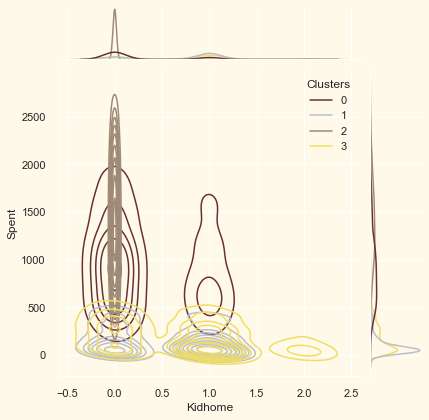

C:\Users\julian.gherghel\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 576x396 with 0 Axes>

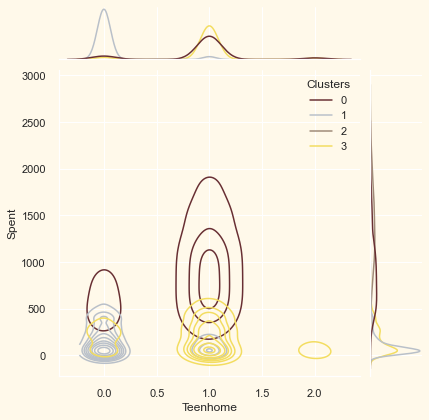

<Figure size 576x396 with 0 Axes>

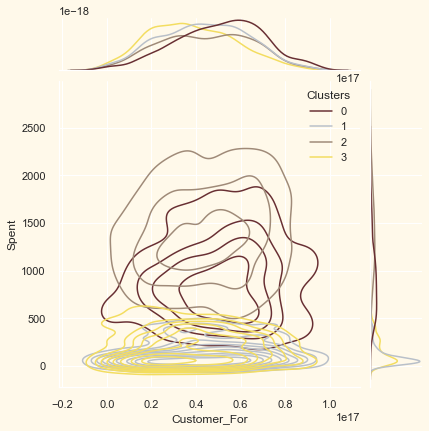

<Figure size 576x396 with 0 Axes>

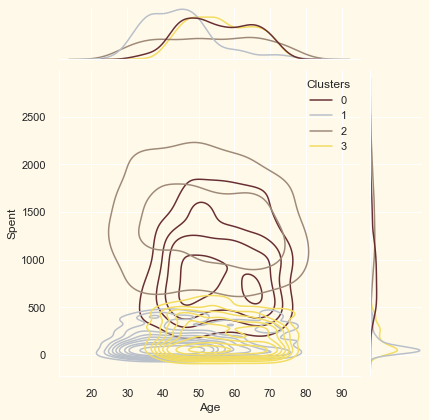

<Figure size 576x396 with 0 Axes>

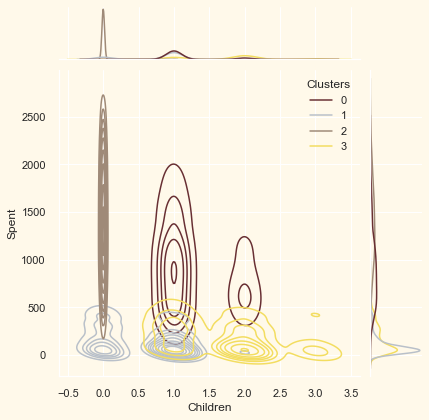

<Figure size 576x396 with 0 Axes>

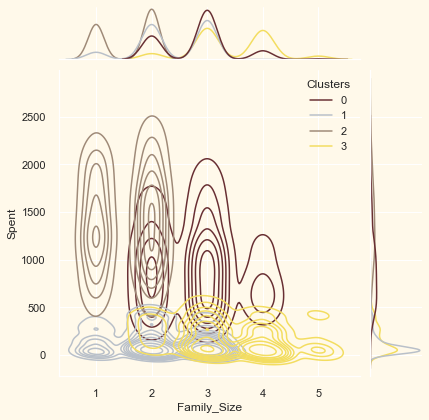

<Figure size 576x396 with 0 Axes>

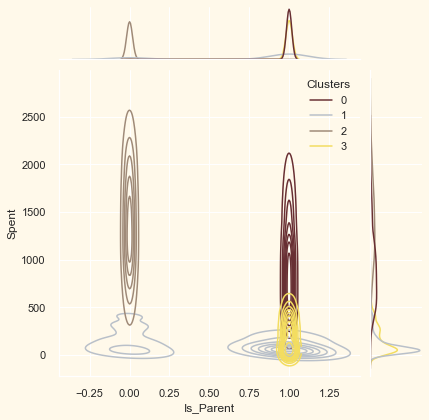

<Figure size 576x396 with 0 Axes>

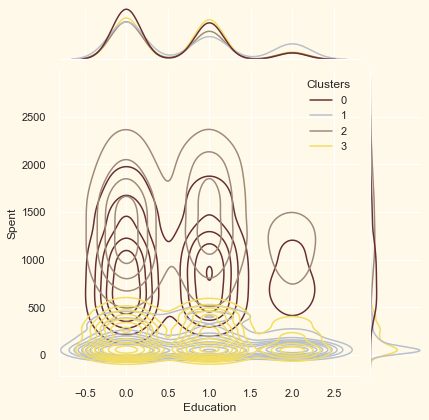

<Figure size 576x396 with 0 Axes>

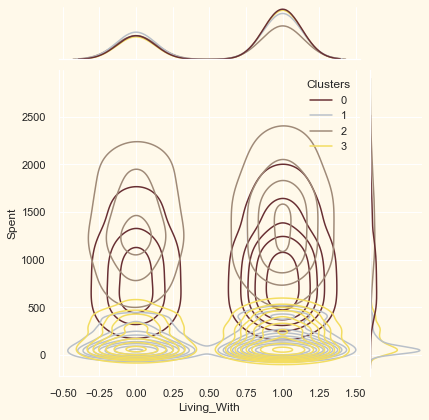

In [70]:
Personal_Traits = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

for trait in Personal_Traits:
    plt.figure()
    sns.jointplot(x=data[trait], y=data["Spent"], hue=data["Clusters"], kind="kde", palette=bar_pallet)
    plt.show()

### About Cluster Number 0:
- Definitely a parent
- Betweent 2 and 4 family members
- Most have a teenager at home
- In the older age groups

### About Cluster Number 1:
- Majority are parents
- Max 3 family members
- Majority have 1 kid (typically not teenagers)
- In the younger age groups

### About Cluster Number 2:
- Definitely not a parent
- Max 2 members in the family
- Slight majority of couples over single people
- Span all age groups
- High income group

### About Cluster Number 4:
- Definitely a parent
- Between 2 and 5 family members
- Majority have 1 teenager at home
- In the older age groups
- Low income group

## Conclusion

Throughout this project, unsupervised clustering has been performed. Dimensionality reducation was employed, followed by agglomerative clustering. Four clusters have been produced and used for customer profiling per cluster according to their household structures, income and spending. The information extracted can be used for planning future marketing strategies.